In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csky as cy
import os
import histlite as hl

timer = cy.timing.Timer()
time = timer.time

# How should the fake data look like?
We probably need to rename and add a few keys in the long run

In [2]:
sig = np.load('/data/ana/analyses/greco_online/version-002-p12/IC86_2012.nue_merged.npy')
data = np.load('/data/ana/analyses/greco_online/version-002-p12/IC86_2012.data.npy')
queso = np.load("/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_120028.npy")


# Get the keys of the dtype fields
keys1 = set(sig.dtype.names)
keys2 = set(data.dtype.names)

# Find common keys
common_keys = keys1.intersection(keys2)

# Print results
print("Comparing GRECO data and Signal")
print("Common Keys:", common_keys)
print("Additional keys that sig has:", keys1 - keys2)
#print("Additional keys that data has:", keys2 - keys1)



# Print results
print()
print("Comparing GRECO data and QUESO MC")
keys1 = set(data.dtype.names)
keys2 = set(queso.dtype.names)
print("Common Keys:", keys1.intersection(keys2))
print("Additional keys that GRECO sig has:", keys1 - keys2)
print("Additional keys that QUESO has:", keys2 - keys1)

# Print results
print()
print("Comparing GRECO sig and QUESO MC")
keys1 = set(sig.dtype.names)
keys2 = set(queso.dtype.names)
print("Common Keys:", keys1.intersection(keys2))
print("Additional keys that GRECO sig has:", keys1 - keys2)
print("Additional keys that QUESO has:", keys2 - keys1)

Comparing GRECO data and Signal
Common Keys: {'monopod_ra', 'azi', 'run', 'cascade_energy', 'monopod_azi', 'ra', 'angErr', 'dec', 'event', 'nchannel', 'monopod_pegleg_dpsi', 'pidPeglegLLH', 'monopod_dec', 'subevent', 'logE', 'angErr_noCorrection', 'time', 'nstring', 'zen', 'index', 'monopod_zen', 'pidMonopodLLH', 'pidDeltaLLH', 'pidLength'}
Additional keys that sig has: {'ow', 'ptype', 'uncorrected_ow', 'genie_gen_r', 'trueRa', 'trueDec', 'iscc', 'trueE', 'prompt', 'conv', 'astro', 'genie_gen_z'}

Comparing GRECO data and QUESO MC
Common Keys: {'logE', 'dec', 'run', 'time', 'event', 'subevent', 'ra'}
Additional keys that GRECO sig has: {'monopod_ra', 'azi', 'angErr_noCorrection', 'pidPeglegLLH', 'monopod_dec', 'nchannel', 'nstring', 'zen', 'cascade_energy', 'index', 'monopod_azi', 'monopod_zen', 'pidMonopodLLH', 'monopod_pegleg_dpsi', 'angErr', 'pidDeltaLLH', 'pidLength'}
Additional keys that QUESO has: {'SplitInIcePulses_dynedge_v2_PulsesUpgradeHitMultiplicity.n_hit_pmts', 'L4_separat

# Read in QUESO MC

In [4]:
path = "/home/mdittmer/Basics/ConvertedQuesoFiles_new/"
prefix = "queso_"

queso_e = np.load(path + prefix + "120028.npy")
queso_ebar = np.load(path + prefix + "121028.npy")
queso_mu = np.load(path + prefix + "140028.npy")
queso_mubar = np.load(path + prefix + "141028.npy")
queso_tau = np.load(path + prefix + "160028.npy")
queso_taubar = np.load(path + prefix + "161028.npy")
queso_muongun = np.load("/home/mdittmer/Basics/ConvertedQuesoFiles_new/muongun_131028.npy")

ArraysToBeUsed = [queso_e, queso_ebar, queso_mu, queso_mubar, queso_tau, queso_taubar, queso_muongun]
del queso_e, queso_ebar, queso_mu, queso_mubar, queso_tau, queso_taubar, queso_muongun


# Remove 'interaction' field from each array since muongun does not have that key
fields_to_drop = ['interaction']

#Remove all keys normally not present in a data file...will be done if needed
#fields_to_drop = ['interaction','trueE', 'trueRa', 'ow', 'genie_gen_z', 'iscc', 'uncorrected_ow', 'astro', 'ptype', 'genie_gen_r', 'conv', 'prompt', 'trueDec']

#Rename QUESO keys...will be done later if needed
#key_mapping = {'old_key1': 'new_key1', 'old_key2': 'new_key2', 'old_key3': 'new_key3'}

cache = []
for e in ArraysToBeUsed:
    modified_array = np.lib.recfunctions.drop_fields(e, fields_to_drop) 
    #modified_array = np.lib.recfunctions.rename_fields(queso_e, key_mapping)
    cache.append(modified_array)
ArraysToBeUsed = cache

# Sample from QUESO interaction type weights for a given livetime and store new numpy array
Iterate over each line in each MC file. Poisson sample from expected events in 3 years. Repeat line x amount of times. Store in new .npy array

In [169]:
import numpy as np

Livetime = 3 * 365 * 24 * 60 * 60  # 3 years

# Initialize List to hold sampled events
storage_list = []

# Iterate over datasets of each interaction type
for dataset in ArraysToBeUsed:
    counter = 0
    print("Going over new interaction type...")
    
    # Initialize List for current interaction type
    current_type_list = []

    for event in dataset:
        # Sample how many times an event (the current row of the interaction type MC) will be present
        Sampled_nr = np.random.poisson(event["atmo_weight"] * Livetime)

        if Sampled_nr == 0:
            continue

        # Store the context of this row Sampled_nr-amount of times in a list
        currentrow = np.repeat(event, Sampled_nr)
        current_type_list.append(currentrow)

        # Count total sampled events over the entire livetime for cross-checking
        counter += Sampled_nr

    # Concatenate all arrays for the current interaction type
    current_type_array = np.concatenate(current_type_list)

    # Append the current interaction type array to the overall list
    storage_list.append(current_type_array)

    print("Sampled events: \t", counter)
    print("Expected events: \t", sum(dataset['atmo_weight'] * Livetime))
    print()

# Concatenate all arrays for different interaction types
Storage = np.concatenate(storage_list)
print("Total events sampled: ", len(Storage))

#Randomize order and save
Shuffled_Array = np.random.permutation(Storage)
np.save('Queso_Fakedata_3Years.npy', Storage)


Going over new interaction type...
Sampled events: 	 136776
Expected events: 	 136157.10228359865

Going over new interaction type...
Sampled events: 	 26234
Expected events: 	 26289.72202428914

Going over new interaction type...
Sampled events: 	 278203
Expected events: 	 277813.4032661558

Going over new interaction type...
Sampled events: 	 243747
Expected events: 	 243149.97034069744

Going over new interaction type...
Sampled events: 	 20013
Expected events: 	 20036.289071908468

Going over new interaction type...
Sampled events: 	 7260
Expected events: 	 7266.33268306121

Going over new interaction type...
Sampled events: 	 58155
Expected events: 	 58365.52531620389

Total events stored:  770388


# Cross-checks
The fake data should have similar distributions as the original MC data? With statistical fluctuation of course.

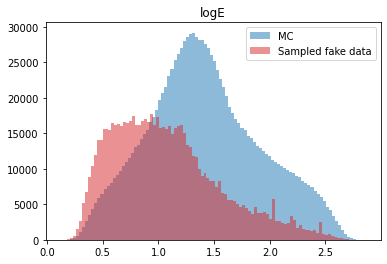

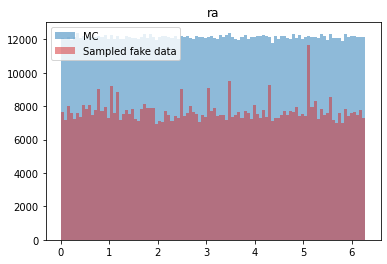

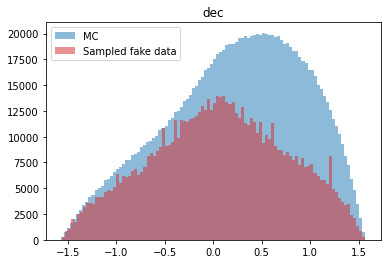

In [5]:
MC_data = np.concatenate(ArraysToBeUsed, axis=0)
Fake_data = np.load('/home/mdittmer/csky/Queso_Fakedata_3Years.npy')

# Make basic histograms for a few keys
KeysToCheck = ['logE', 'ra', 'dec']
for key in KeysToCheck:
    plt.figure()
    plt.title(key)
    plt.hist(MC_data[key]  ,bins=100,color='tab:blue',label='MC',alpha=0.5)
    plt.hist(Fake_data[key],bins=100,color='tab:red',label='Sampled fake data',alpha=0.5)
    plt.legend()
    plt.show()

How does this look for GRECO?

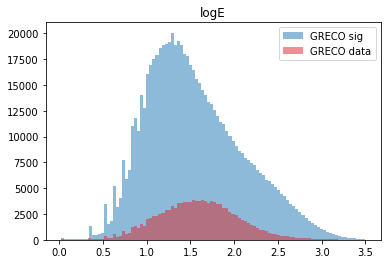

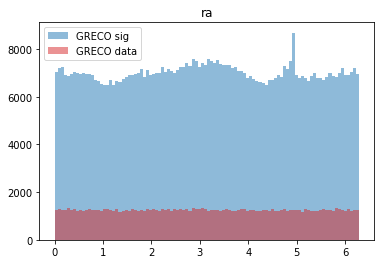

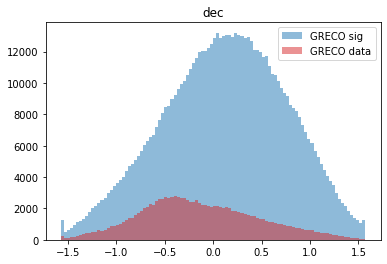

In [6]:
sig = np.load('/data/ana/analyses/greco_online/version-002-p12/IC86_2012.nue_merged.npy')
data = np.load('/data/ana/analyses/greco_online/version-002-p12/IC86_2012.data.npy')

# Make basic histograms for a few keys
KeysToCheck = ['logE', 'ra', 'dec']
for key in KeysToCheck:
    plt.figure()
    plt.title(key)
    plt.hist(sig[key]  ,bins=100,color='tab:blue',label='GRECO sig', alpha=0.5)
    plt.hist(data[key],bins=100,color='tab:red',label='GRECO data', alpha=0.5)
    plt.legend()
    plt.show()

Not sure what to learn from this...

# Creating fake GRL

In [ ]:
current_mjd = 60369
runstart = 135328
run_duration = 1/3 #8h
nr_runs = 2000
background_event_rate = 0.004586764119128693 #1/s
background_events = int(np.round(background_event_rate * (run_duration*24*60*60),0))

new_grl_entries = []
dtype = [('run', int), ('start', np.float64), ('stop', np.float64), ('livetime', np.float64), ('events', int)]
for i in range(runstart, runstart+nr_runs+1):  
    new_grl_entries.append((i, current_mjd, current_mjd + run_duration, run_duration, background_events))  
    current_mjd += run_duration

grl = np.array(new_grl_entries, dtype=dtype)
np.save('queso_fake_GRL.npy',grl)

# Background estimation in csky

## using our QUESO files

In [15]:
import csky as cy

# Create an instance of the GRECO_IC86_2012_2019 class
queso_spec = cy.selections.GRECOOnlineDataSpecs.GRECO_IC86_2012_2019()

# Set file paths to load in our QUESO files. A proper class will be written for this
queso_spec.path_sig = [
    '/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_120028.npy',
    "/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_121028.npy",
    "/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_140028.npy",
    "/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_141028.npy",
    "/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_160028.npy",
    "/home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_161028.npy",
    #"/home/mdittmer/Basics/ConvertedQuesoFiles_new/muongun_131028.npy"
]
queso_spec.path_data = [
    '/home/mdittmer/csky/Queso_Fakedata_3Years.npy'
]
queso_spec.path_grls = [
    '/home/mdittmer/csky/queso_fake_GRL.npy'
]


# Call the load method to load the data
dataset = queso_spec.load(cy.selections.repo)

# Access the loaded data
print(dataset)

Reading /home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_120028.npy ...
Reading /home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_121028.npy ...
Reading /home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_140028.npy ...
Reading /home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_141028.npy ...
Reading /home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_160028.npy ...
Reading /home/mdittmer/Basics/ConvertedQuesoFiles_new/queso_161028.npy ...
Reading /home/mdittmer/csky/Queso_Fakedata_3Years.npy ...
Reading /home/mdittmer/csky/queso_fake_GRL.npy ...
Dataset('GRECO_IC86_2012_2019', livetime = 57628800s) with 770388 data events and no background MC loaded and sum(ow*E^-2) = 6.45


In [16]:
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 3

src = cy.sources(180, 0, deg=True)
tr = cy.get_trial_runner(src=src)

In [20]:
bg = cy.dists.Chi2TSD(tr.get_many_fits(1000))

Performing 1000 background trials using 3 cores:
       1000/1000 trials complete.   


/mnt/ceph1-npx/user/mdittmer/software/csky_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


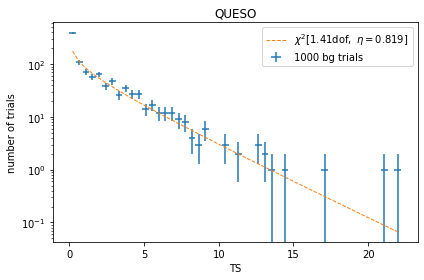

In [21]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.title('QUESO')
plt.tight_layout()
plt.savefig('TS_Queso.png')

## Using ESTES approach

In the 2022 ESTES analysis, we found that they have the option to use mc data as bg which we tried to adapt for our needs.

https://github.com/icecube/wg-nu-sources/blob/main/2022_ESTES_Analyses/NSScripts_csky/csky_allsky_bgts.py#L70

In [2]:
use_mcbg = True
n_trials  = 1000
n_cpu     = 1

timer = cy.timing.Timer()
time  = timer.time

#load dataset
#
ana = cy.get_analysis(cy.selections.repo,'version-001-p00',cy.selections.QUESODataSpecs.QUESO,space_bg_kw={'bg_mc_weight':'atmo_weight'},energy_kw = {'bg_mc_weight':'atmo_weight'},load_sig=True)

cy.CONF['ana']     = ana
cy.CONF['mp_cpus'] = n_cpu


#create the source object for checking at a given declination
src  = cy.sources(180, 0, deg=True)

#set randomization settings for the data injectors
if use_mcbg:
    #use mc to model background
    #scramble declination using reconstructed ang error, sigma, for bg trials
    inj_conf =  {'bg_weight_names':['atmo_weight'],
                 'randomize'      :['ra', 'dec']}
    update_bg = False
else:
    #use data to model background
    #scramble declination using perscribed randomization width for bg trials
    inj_conf =  {'randomize':['ra', 'dec']}
    inj_conf = {'randomize': ['ra', cy.inj.DecRandomizer],
                'sindec_bandwidth': np.radians(5),
                'dec_rand_method': 'gaussian_fixed',
                'dec_rand_kwargs': dict(randomization_width=np.radians(3)),
                'dec_rand_pole_exlusion': np.radians(8)}
    update_bg = True
tr = cy.get_trial_runner(inj_conf = inj_conf,
                         src = src, 
                         update_bg = update_bg)


Setting up Analysis for:
QUESO
Setting up QUESO...
Reading /data/user/bschlueter/software/nusources_dataset_converters/data/QUESO_MC_all_combined_without_muongun.npy ...
Reading /data/user/bschlueter/software/nusources_dataset_converters/data/Queso_Fakedata_3Years.npy ...
Reading /data/user/bschlueter/software/nusources_dataset_converters/data/QUESO_fake_GRL.npy ...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [ ]:
bg = cy.dists.Chi2TSD(tr.get_many_fits(1000))

Performing 1000 background trials using 1 core:
        600/1000 trials complete...

/mnt/ceph1-npx/user/mdittmer/software/csky_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


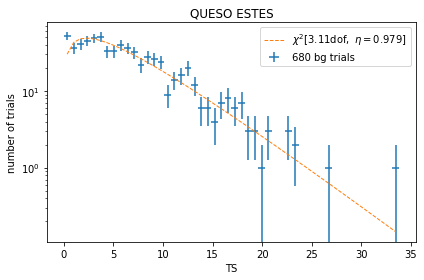

In [4]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.title('QUESO ESTES')
plt.tight_layout()
plt.savefig('TS_Queso_estes.png')

## Greco comparison

In [7]:
#read in greco
ana_dir = '/home/mdittmer/csky/Greco_repo/'
if os.path.exists(ana_dir) == False:
    os.mkdir(ana_dir)

ana_dir = cy.utils.ensure_dir(ana_dir)

ana = cy.get_analysis(
    cy.selections.repo,
    'version-002-p10',
    cy.selections.GRECOOnlineDataSpecs.GRECO_IC86_2012_2019,
    dir=ana_dir)
ana.save(ana_dir)

Setting up Analysis for:
GRECO_IC86_2012_2019
Setting up GRECO_IC86_2012_2019...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.nue_merged.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.numu_merged.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.nutau_merged.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2013.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2014.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2015.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2016.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2017.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2018.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2019.data.npy ...
Reading /data/ana/analyses/gr

In [8]:
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 3

src = cy.sources(180, 0, deg=True)
tr = cy.get_trial_runner(src=src)



In [12]:
bg = cy.dists.Chi2TSD(tr.get_many_fits(1000))

Performing 1000 background trials using 3 cores:
       1000/1000 trials complete.   


/mnt/ceph1-npx/user/mdittmer/software/csky_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


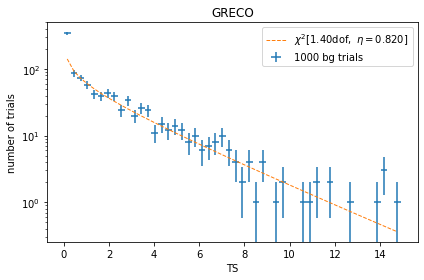

In [13]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.title('GRECO')
plt.tight_layout()
plt.savefig('TS_Greco.png')